In this notebook we implement the stage 1 of the phononet architecture in tensorflow. We use the phononet library to just extract the chromogram data.

In [1]:
import matplotlib.pyplot as plt
import json
from collections import Counter

%matplotlib inline

import sys
import os

%load_ext autoreload
%autoreload 2


In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  0


In [3]:
sys.path.append('../')

In [4]:
import phononet as pn
import utils

In [5]:
include_files = json.load(open('SankalpRagaDataset.json'))  # import list of song_ids to include
cd = pn.FullChromaDataset('hindustaniv2.json', '../../n_ftt4096__hop_length2048',
                          include_mbids=include_files)  # load dataset of "full song" chromagrams
train, test = cd.train_test_split(train_size=0.75)  # split training and test sets from "full song" chromagrams
train = pn.ChromaChunkDataset(train, chunk_size=1500)  # divide training set into chunks of width 150
test = pn.ChromaChunkDataset(test, chunk_size=1500)

Loading Chromagram Files: 100%|██████████| 300/300 [00:00<00:00, 2031.14it/s]


In [6]:
#raga_detector = pn.RagaDetector(batch_size=32, gpus=1)
#raga_detector.fit(train, test)

In [7]:
X_train=train.X.numpy()
y_train=np.array(train.y).astype(np.int8)

X_val=test.X.numpy()
y_val=np.array(test.y).astype(np.int8)

<BarContainer object of 30 artists>

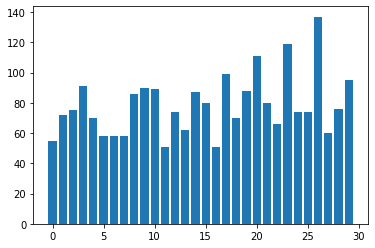

In [8]:
a,b=zip(*sorted(Counter(y_train).items(),key=lambda x:x[0]))
plt.bar(a,b)

In [9]:
from collections import Counter
counter=Counter(y_train)
weights=np.array([1/counter[val] for val in y_train])
weights/=weights.sum()
idxs=np.random.choice(range(len(y_train)),len(y_train),p=weights)

<BarContainer object of 30 artists>

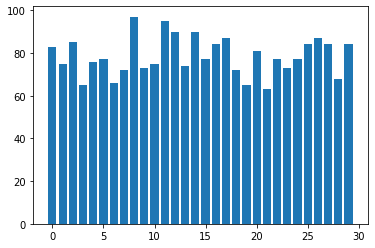

In [10]:
a,b=zip(*sorted(Counter(y_train[idxs]).items(),key=lambda x:x[0]))
plt.bar(a,b)

In [11]:
def gen(X,y,augment,balanced):
    n=len(X)
    
    if balanced:
        counter=Counter(y)
        weights=np.array([1/counter[val] for val in y])
        weights/=weights.sum()
        idxs=np.random.choice(range(n),n,p=weights)
    else:
        idxs=list(range(n))
        
    offsets=np.random.randint(12,size=n)
    np.random.shuffle(idxs)
    
    l=list(range(12))
    
    ls=[]
    for i in range(12):
        ls.append(l[i:]+l[:i])
    
    for idx,i in zip(idxs,offsets):
        if augment:
            yield X[idx].take(ls[i],axis=0),y[idx]
        else:
            yield X[idx],y[idx]




In [12]:
BATCH_SIZE=32
AUGMENT=True
BALANCED=True
train_data=tf.data.Dataset.from_generator(generator=gen,args=(X_train,y_train,AUGMENT,BALANCED),
                                           output_shapes=(tf.TensorShape([12,1500]),tf.TensorShape([])),
                                           output_types=(tf.float32,tf.int8)
                                          ).repeat().batch(BATCH_SIZE)
val_data=tf.data.Dataset.from_tensor_slices((X_val,y_val)).shuffle(1000).batch(BATCH_SIZE)

In [13]:
from tensorflow.keras.layers import Conv2D
from utils import MySequential, ConfusionMatrixMetric, PeriodicPaddingConv2D

In [14]:
ConvLayer=Conv2D

In [15]:
class ConvBlock(keras.layers.Layer):
    
    def __init__(self,*args,**kwargs):
        name=kwargs.pop('name',None)
        super().__init__(name=name)
        self.max_pool=kwargs.pop('max_pool',None)
        self.dropout=kwargs.pop('dropout',None)
        self.zero_padding=kwargs.pop('zero_padding',None)
        self.args=args
        self.kwargs=kwargs
        
        
    def build(self,input_shape):
        layers=[tf.keras.layers.Input(shape=input_shape[1:])]
        if self.zero_padding is not None:
            layers.append(tf.keras.layers.ZeroPadding2D(padding=self.zero_padding))
        layers.extend([
            ConvLayer(*self.args,**self.kwargs),
            keras.layers.LeakyReLU(alpha=leaky_relu_parameter),
            keras.layers.BatchNormalization(axis=[3]), # batch normalization on everything but last dimension
        ])
        if self.max_pool is not None:
            layers.append(keras.layers.MaxPool2D(self.max_pool))
        if self.dropout is not None:
            layers.append(keras.layers.Dropout(self.dropout))
        self.model=keras.Sequential(layers)
        
    def call(self,x):
        return self.model(x)

In [19]:
from tensorflow.keras import Sequential

In [16]:
class OnlyTimeConvolution(tf.keras.layers.Layer):
    
    def __init__(self,num_filters,filter_size,*args,**kwargs):
        name=kwargs.pop('name',None)
        super().__init__(name=name)
        self.tr1=keras.layers.Lambda(lambda x: tf.transpose(x,[0,2,1,3]))
        self.tr2=keras.layers.Lambda(lambda x: tf.transpose(x,[0,2,1,3]))
        self.c=tf.keras.layers.Conv1D(num_filters,
                               filter_size,
                               data_format='channels_last',*args,**kwargs)
    
    def build(self,input_shape):
        self.num_channels=input_shape[1]
        
    def call(self,x):
        
        x=self.tr1(x)
        x=tf.stack([self.c(x[:,:,i]) for i in range(self.num_channels)],2)
        x=self.tr2(x)
        return x

In [17]:
120/1500*15

1.2

In [25]:
kernel_initializer='he_uniform'
leaky_relu_parameter=1e-2
initial_time_only_conv=Sequential([
    OnlyTimeConvolution(100,100,strides=5,name='only_time_convolution',kernel_initializer=kernel_initializer),
    keras.layers.LeakyReLU(alpha=leaky_relu_parameter),
    keras.layers.BatchNormalization(axis=[3]),
    keras.layers.MaxPool2D((1,2)),
    Conv2D(1,(1,1),padding='same'),
    #
    #OnlyTimeConvolution(100,50,strides=5,name='only_time_convolution2',kernel_initializer=kernel_initializer),
    #keras.layers.LeakyReLU(alpha=leaky_relu_parameter),
    #keras.layers.BatchNormalization(axis=[3]),
    #keras.layers.MaxPool2D((1,2)),
    #Conv2D(1,(1,1),padding='same'),
    #
],name='initial_time_only_conv_encoder')
model=MySequential([
    keras.layers.Input(shape=(12,1500)),
    keras.layers.Lambda(lambda x: tf.expand_dims(x,-1),name='expand_dims'),
    keras.layers.BatchNormalization(axis=[3],name='norm0'),
    #
    initial_time_only_conv
]).summary()

Model: "my_sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
expand_dims (Lambda)         (None, 12, 1500, 1)       0         
_________________________________________________________________
norm0 (BatchNormalization)   (None, 12, 1500, 1)       4         
_________________________________________________________________
initial_time_only_conv_encod (None, 12, 140, 1)        10601     
Total params: 10,605
Trainable params: 10,403
Non-trainable params: 202
_________________________________________________________________


In [30]:
dropout_prob=0.3
PADDING_TYPE='valid'

model=MySequential([
    keras.layers.Input(shape=(12,1500)),
    keras.layers.Lambda(lambda x: tf.expand_dims(x,-1),name='expand_dims'),
    keras.layers.BatchNormalization(axis=[3],name='norm0'),
    #
    initial_time_only_conv,
    #
    ConvBlock(64,(3,3),
              name='conv_block_1',
              zero_padding=(0,1),
              padding=PADDING_TYPE,
              kernel_initializer=kernel_initializer,
              max_pool=(1,2),
              dropout=dropout_prob,
             ),
    ConvBlock(128,(3,3),
              name='conv_block_2',
              zero_padding=(0,1),
              padding=PADDING_TYPE,
              kernel_initializer=kernel_initializer,
              max_pool=(1,3),
              dropout=dropout_prob,
             ),
    ConvBlock(150,(3,3),
              name='conv_block_3',
              zero_padding=(0,1),
              padding=PADDING_TYPE,
              kernel_initializer=kernel_initializer,
              max_pool=(1,2),
              dropout=dropout_prob,
             ),
    ConvBlock(200,(3,3),
              name='conv_block_4',
              padding='same',
              kernel_initializer=kernel_initializer,
             ),
    keras.layers.GlobalAveragePooling2D(name='gba'),
    keras.layers.Dropout(dropout_prob,name='drop4'),
    #
    keras.layers.Dense(30,name='fc',kernel_initializer=kernel_initializer)

])

model.summary()

Model: "my_sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
expand_dims (Lambda)         (None, 12, 1500, 1)       0         
_________________________________________________________________
norm0 (BatchNormalization)   (None, 12, 1500, 1)       4         
_________________________________________________________________
initial_time_only_conv_encod (None, 12, 140, 1)        10601     
_________________________________________________________________
conv_block_1 (ConvBlock)     (None, 10, 70, 64)        896       
_________________________________________________________________
conv_block_2 (ConvBlock)     (None, 8, 23, 128)        74368     
_________________________________________________________________
conv_block_3 (ConvBlock)     (None, 6, 11, 150)        173550    
_________________________________________________________________
conv_block_4 (ConvBlock)     (None, 6, 11, 200)    

In [31]:
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy',ConfusionMatrixMetric(30)])

In [32]:
history=model.fit(train_data,validation_data=val_data,epochs=100,steps_per_epoch=len(X_train)//BATCH_SIZE,verbose=1)

Epoch 1/100
73/73 [==============================] - 26s 358ms/step - loss: 3.4346 - accuracy: 0.0432 - F1_0: 0.0682 - F1_1: 0.0118 - F1_2: 0.1102 - F1_3: 0.0477 - F1_4: 0.0632 - F1_5: 0.0763 - F1_6: 0.0603 - F1_7: 0.0490 - F1_8: 0.0100 - F1_9: 0.0338 - F1_10: 0.0050 - F1_11: 0.0247 - F1_12: 0.0000e+00 - F1_13: 7.1833e-04 - F1_14: 0.0465 - F1_15: 0.0288 - F1_16: 0.0999 - F1_17: 0.0099 - F1_18: 0.0000e+00 - F1_19: 0.0476 - F1_20: 0.0082 - F1_21: 0.0548 - F1_22: 0.0336 - F1_23: 0.0378 - F1_24: 0.0478 - F1_25: 0.0108 - F1_26: 0.0666 - F1_27: 0.0312 - F1_28: 0.0000e+00 - F1_29: 0.0252 - val_loss: 4.0657 - val_accuracy: 0.0281 - val_F1_0: 0.0000e+00 - val_F1_1: 0.0000e+00 - val_F1_2: 0.0000e+00 - val_F1_3: 0.0000e+00 - val_F1_4: 0.0000e+00 - val_F1_5: 0.0000e+00 - val_F1_6: 0.0465 - val_F1_7: 0.0000e+00 - val_F1_8: 0.0557 - val_F1_9: 0.0000e+00 - val_F1_10: 0.0000e+00 - val_F1_11: 0.0000e+00 - val_F1_12: 0.0000e+00 - val_F1_13: 0.0000e+00 - val_F1_14: 0.0000e+00 - val_F1_15: 0.0000e+00 - va

73/73 [==============================] - 26s 363ms/step - loss: 1.9727 - accuracy: 0.4199 - F1_0: 0.4119 - F1_1: 0.3631 - F1_2: 0.5545 - F1_3: 0.1996 - F1_4: 0.6278 - F1_5: 0.5017 - F1_6: 0.3879 - F1_7: 0.4649 - F1_8: 0.5699 - F1_9: 0.5012 - F1_10: 0.3350 - F1_11: 0.3782 - F1_12: 0.1783 - F1_13: 0.3240 - F1_14: 0.2792 - F1_15: 0.4126 - F1_16: 0.4870 - F1_17: 0.2646 - F1_18: 0.4966 - F1_19: 0.4159 - F1_20: 0.3503 - F1_21: 0.3112 - F1_22: 0.3331 - F1_23: 0.3403 - F1_24: 0.3213 - F1_25: 0.3067 - F1_26: 0.5016 - F1_27: 0.3749 - F1_28: 0.4065 - F1_29: 0.3259 - val_loss: 2.5908 - val_accuracy: 0.3103 - val_F1_0: 0.3077 - val_F1_1: 0.0000e+00 - val_F1_2: 0.0000e+00 - val_F1_3: 0.0000e+00 - val_F1_4: 0.6190 - val_F1_5: 0.1923 - val_F1_6: 0.6765 - val_F1_7: 0.7105 - val_F1_8: 0.2359 - val_F1_9: 0.2222 - val_F1_10: 0.4658 - val_F1_11: 0.0000e+00 - val_F1_12: 0.0417 - val_F1_13: 0.0000e+00 - val_F1_14: 0.3400 - val_F1_15: 0.3846 - val_F1_16: 0.3019 - val_F1_17: 0.0889 - val_F1_18: 0.1471 - val_F1

Epoch 14/100
73/73 [==============================] - 26s 359ms/step - loss: 1.2856 - accuracy: 0.6092 - F1_0: 0.6508 - F1_1: 0.5284 - F1_2: 0.6743 - F1_3: 0.5067 - F1_4: 0.8916 - F1_5: 0.5417 - F1_6: 0.7097 - F1_7: 0.5179 - F1_8: 0.6766 - F1_9: 0.4900 - F1_10: 0.6991 - F1_11: 0.6346 - F1_12: 0.4727 - F1_13: 0.4847 - F1_14: 0.6501 - F1_15: 0.7864 - F1_16: 0.5741 - F1_17: 0.4822 - F1_18: 0.7494 - F1_19: 0.5804 - F1_20: 0.6279 - F1_21: 0.6728 - F1_22: 0.5071 - F1_23: 0.5712 - F1_24: 0.5334 - F1_25: 0.4405 - F1_26: 0.6245 - F1_27: 0.5884 - F1_28: 0.5766 - F1_29: 0.5550 - val_loss: 2.1564 - val_accuracy: 0.4049 - val_F1_0: 0.4557 - val_F1_1: 0.3846 - val_F1_2: 0.0870 - val_F1_3: 0.0930 - val_F1_4: 0.8387 - val_F1_5: 0.2727 - val_F1_6: 0.3243 - val_F1_7: 0.7872 - val_F1_8: 0.3571 - val_F1_9: 0.1250 - val_F1_10: 0.5897 - val_F1_11: 0.0909 - val_F1_12: 0.2903 - val_F1_13: 0.0000e+00 - val_F1_14: 0.4138 - val_F1_15: 0.4324 - val_F1_16: 0.3529 - val_F1_17: 0.2308 - val_F1_18: 0.2727 - val_F1_19

Epoch 21/100
73/73 [==============================] - 26s 359ms/step - loss: 0.9577 - accuracy: 0.7145 - F1_0: 0.8031 - F1_1: 0.6062 - F1_2: 0.6986 - F1_3: 0.6398 - F1_4: 0.9133 - F1_5: 0.7771 - F1_6: 0.7006 - F1_7: 0.7243 - F1_8: 0.8114 - F1_9: 0.7140 - F1_10: 0.8379 - F1_11: 0.6238 - F1_12: 0.5898 - F1_13: 0.7266 - F1_14: 0.5815 - F1_15: 0.8162 - F1_16: 0.6496 - F1_17: 0.5738 - F1_18: 0.7748 - F1_19: 0.7985 - F1_20: 0.7151 - F1_21: 0.5899 - F1_22: 0.6631 - F1_23: 0.7525 - F1_24: 0.5968 - F1_25: 0.6569 - F1_26: 0.8159 - F1_27: 0.7847 - F1_28: 0.6179 - F1_29: 0.6329 - val_loss: 2.2901 - val_accuracy: 0.4087 - val_F1_0: 0.5867 - val_F1_1: 0.4167 - val_F1_2: 0.1290 - val_F1_3: 0.2174 - val_F1_4: 0.7027 - val_F1_5: 0.2364 - val_F1_6: 0.6400 - val_F1_7: 0.7595 - val_F1_8: 0.4068 - val_F1_9: 0.2353 - val_F1_10: 0.6154 - val_F1_11: 0.0690 - val_F1_12: 0.0444 - val_F1_13: 0.1667 - val_F1_14: 0.3448 - val_F1_15: 0.4118 - val_F1_16: 0.3922 - val_F1_17: 0.0444 - val_F1_18: 0.2545 - val_F1_19: 0.

Epoch 28/100
73/73 [==============================] - 25s 339ms/step - loss: 0.6587 - accuracy: 0.8005 - F1_0: 0.8510 - F1_1: 0.6753 - F1_2: 0.7736 - F1_3: 0.7239 - F1_4: 0.8982 - F1_5: 0.9030 - F1_6: 0.8448 - F1_7: 0.8071 - F1_8: 0.8132 - F1_9: 0.8224 - F1_10: 0.8533 - F1_11: 0.7257 - F1_12: 0.8168 - F1_13: 0.7655 - F1_14: 0.7005 - F1_15: 0.8852 - F1_16: 0.7461 - F1_17: 0.8021 - F1_18: 0.9299 - F1_19: 0.7998 - F1_20: 0.7933 - F1_21: 0.6909 - F1_22: 0.8159 - F1_23: 0.7661 - F1_24: 0.8142 - F1_25: 0.7400 - F1_26: 0.8384 - F1_27: 0.8548 - F1_28: 0.8132 - F1_29: 0.6901 - val_loss: 2.1091 - val_accuracy: 0.4789 - val_F1_0: 0.5714 - val_F1_1: 0.4444 - val_F1_2: 0.3000 - val_F1_3: 0.3333 - val_F1_4: 0.8485 - val_F1_5: 0.3774 - val_F1_6: 0.7059 - val_F1_7: 0.6957 - val_F1_8: 0.5106 - val_F1_9: 0.2353 - val_F1_10: 0.4444 - val_F1_11: 0.1633 - val_F1_12: 0.0000e+00 - val_F1_13: 0.3077 - val_F1_14: 0.4211 - val_F1_15: 0.4667 - val_F1_16: 0.6531 - val_F1_17: 0.1587 - val_F1_18: 0.5833 - val_F1_19

Epoch 40/100
73/73 [==============================] - 25s 342ms/step - loss: 0.4595 - accuracy: 0.8630 - F1_0: 0.9311 - F1_1: 0.7520 - F1_2: 0.8577 - F1_3: 0.7489 - F1_4: 0.8524 - F1_5: 0.8112 - F1_6: 0.9277 - F1_7: 0.9020 - F1_8: 0.9268 - F1_9: 0.8820 - F1_10: 0.9317 - F1_11: 0.8711 - F1_12: 0.7322 - F1_13: 0.8448 - F1_14: 0.7060 - F1_15: 0.9002 - F1_16: 0.8626 - F1_17: 0.8123 - F1_18: 0.9505 - F1_19: 0.9253 - F1_20: 0.7775 - F1_21: 0.8946 - F1_22: 0.8188 - F1_23: 0.8242 - F1_24: 0.7631 - F1_25: 0.8186 - F1_26: 0.8494 - F1_27: 0.8657 - F1_28: 0.9066 - F1_29: 0.7901 - val_loss: 2.1896 - val_accuracy: 0.5045 - val_F1_0: 0.5574 - val_F1_1: 0.6154 - val_F1_2: 0.1364 - val_F1_3: 0.3704 - val_F1_4: 0.8333 - val_F1_5: 0.2927 - val_F1_6: 0.5490 - val_F1_7: 0.6875 - val_F1_8: 0.6176 - val_F1_9: 0.1250 - val_F1_10: 0.8132 - val_F1_11: 0.1000 - val_F1_12: 0.2500 - val_F1_13: 0.3636 - val_F1_14: 0.6301 - val_F1_15: 0.4545 - val_F1_16: 0.5185 - val_F1_17: 0.2857 - val_F1_18: 0.5000 - val_F1_19: 0.

Epoch 47/100
73/73 [==============================] - 25s 344ms/step - loss: 0.3893 - accuracy: 0.8896 - F1_0: 0.9019 - F1_1: 0.7359 - F1_2: 0.8887 - F1_3: 0.8649 - F1_4: 0.9391 - F1_5: 0.9067 - F1_6: 0.9690 - F1_7: 0.8246 - F1_8: 0.9275 - F1_9: 0.9060 - F1_10: 0.8779 - F1_11: 0.8587 - F1_12: 0.8636 - F1_13: 0.9024 - F1_14: 0.8514 - F1_15: 0.9091 - F1_16: 0.8608 - F1_17: 0.8265 - F1_18: 0.8858 - F1_19: 0.8690 - F1_20: 0.8933 - F1_21: 0.9455 - F1_22: 0.8974 - F1_23: 0.8369 - F1_24: 0.8607 - F1_25: 0.9027 - F1_26: 0.9088 - F1_27: 0.8579 - F1_28: 0.9231 - F1_29: 0.8341 - val_loss: 2.1405 - val_accuracy: 0.5236 - val_F1_0: 0.6333 - val_F1_1: 0.6207 - val_F1_2: 0.2308 - val_F1_3: 0.3600 - val_F1_4: 0.7778 - val_F1_5: 0.2917 - val_F1_6: 0.5758 - val_F1_7: 0.7671 - val_F1_8: 0.6027 - val_F1_9: 0.3333 - val_F1_10: 0.8000 - val_F1_11: 0.0816 - val_F1_12: 0.0455 - val_F1_13: 0.2857 - val_F1_14: 0.5405 - val_F1_15: 0.4571 - val_F1_16: 0.4286 - val_F1_17: 0.3051 - val_F1_18: 0.5294 - val_F1_19: 0.

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



73/73 [==============================] - 26s 358ms/step - loss: 0.1808 - accuracy: 0.9469 - F1_0: 0.9526 - F1_1: 0.8688 - F1_2: 0.9759 - F1_3: 0.9608 - F1_4: 0.9649 - F1_5: 0.9417 - F1_6: 0.9452 - F1_7: 0.9773 - F1_8: 0.9315 - F1_9: 0.9662 - F1_10: 0.8685 - F1_11: 0.9731 - F1_12: 0.9106 - F1_13: 0.9696 - F1_14: 0.9522 - F1_15: 0.9349 - F1_16: 0.9076 - F1_17: 0.9517 - F1_18: 0.9620 - F1_19: 0.9542 - F1_20: 0.9405 - F1_21: 0.9094 - F1_22: 0.8961 - F1_23: 0.8934 - F1_24: 0.8986 - F1_25: 0.9691 - F1_26: 0.9616 - F1_27: 0.9031 - F1_28: 0.9555 - F1_29: 0.8275 - val_loss: 2.4305 - val_accuracy: 0.5338 - val_F1_0: 0.6552 - val_F1_1: 0.5098 - val_F1_2: 0.1500 - val_F1_3: 0.4928 - val_F1_4: 0.7568 - val_F1_5: 0.3226 - val_F1_6: 0.4878 - val_F1_7: 0.6667 - val_F1_8: 0.6154 - val_F1_9: 0.3158 - val_F1_10: 0.8298 - val_F1_11: 0.1111 - val_F1_12: 0.1633 - val_F1_13: 0.2727 - val_F1_14: 0.5870 - val_F1_15: 0.5833 - val_F1_16: 0.4444 - val_F1_17: 0.4928 - val_F1_18: 0.6957 - val_F1_19: 0.6061 - val_F1

Epoch 94/100
73/73 [==============================] - 28s 379ms/step - loss: 0.1884 - accuracy: 0.9426 - F1_0: 0.9095 - F1_1: 0.8992 - F1_2: 0.9223 - F1_3: 0.9471 - F1_4: 0.9810 - F1_5: 0.9729 - F1_6: 0.9687 - F1_7: 0.9084 - F1_8: 0.9614 - F1_9: 0.8672 - F1_10: 0.9581 - F1_11: 0.9833 - F1_12: 0.9383 - F1_13: 0.9695 - F1_14: 0.9553 - F1_15: 0.9459 - F1_16: 0.8750 - F1_17: 0.9762 - F1_18: 0.9836 - F1_19: 0.9436 - F1_20: 0.9087 - F1_21: 0.8828 - F1_22: 0.8530 - F1_23: 0.9029 - F1_24: 0.9802 - F1_25: 0.8293 - F1_26: 0.9761 - F1_27: 0.9575 - F1_28: 0.9622 - F1_29: 0.9161 - val_loss: 2.3060 - val_accuracy: 0.5530 - val_F1_0: 0.7692 - val_F1_1: 0.4828 - val_F1_2: 0.0667 - val_F1_3: 0.4127 - val_F1_4: 0.9412 - val_F1_5: 0.2000 - val_F1_6: 0.5614 - val_F1_7: 0.8108 - val_F1_8: 0.5263 - val_F1_9: 0.2400 - val_F1_10: 0.7442 - val_F1_11: 0.1250 - val_F1_12: 0.6265 - val_F1_13: 0.2667 - val_F1_14: 0.5758 - val_F1_15: 0.4571 - val_F1_16: 0.5000 - val_F1_17: 0.4062 - val_F1_18: 0.4615 - val_F1_19: 0.

In [33]:
TRAINING_HISTORY_FOLDER='training_history'
os.makedirs(TRAINING_HISTORY_FOLDER,exist_ok=True)
TRAINING_HISTORY_FILENAME = 'tmp3.json'

training_history_file=os.path.join(TRAINING_HISTORY_FOLDER,TRAINING_HISTORY_FILENAME)

In [34]:
#model.save_weights('phase_1_weights_100_epochs')

In [35]:
json.dump(history.history,open(training_history_file,'w'),indent=2)

In [36]:
training_history_file

'training_history/tmp3.json'

In [37]:
history_dict_unaugmented=json.load(open(os.path.join(TRAINING_HISTORY_FOLDER,'unaugmented.json')))
history_dict_augmented=json.load(open(os.path.join(TRAINING_HISTORY_FOLDER,'augmented.json')))
history_dict=json.load(open(training_history_file))

In [38]:
ragas_idx={'Abhogi': 0, 'Ahir bhairav': 1, 'Alahiya bilawal': 2, 'Bageshree': 3, 'Bairagi': 4, 'Basant': 5, 'Bhairav': 6, 'Bhoop': 7, 'Bihag': 8, 'Bilaskhani todi': 9, 'Darbari': 10, 'Des': 11, 'Gaud malhar': 12, 'Hamsadhvani': 13, 'Jog': 14, 'Kedar': 15, 'Khamaj': 16, 'Lalat': 17, 'Madhukauns': 18, 'Madhuvanti': 19, 'Malkauns': 20, 'Marubihag': 21, 'Marwa': 22, 'Miya malhar': 23, 'Puriya dhanashree': 24, 'Rageshri': 25, 'Shree': 26, 'Shuddh sarang': 27, 'Todi': 28, 'Yaman kalyan': 29}

In [39]:
ragas_reverse_idx={v:k for k,v in ragas_idx.items()}

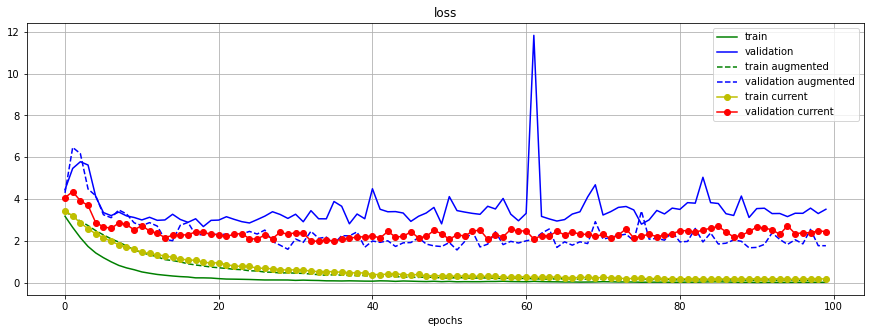

In [40]:
plt.figure(figsize=(15,5))
plt.plot(history_dict_unaugmented['loss'],'g-',label='train')
plt.plot(history_dict_unaugmented['val_loss'],'b-',label='validation')
plt.plot(history_dict_augmented['loss'],'g--',label='train augmented')
plt.plot(history_dict_augmented['val_loss'],'b--',label='validation augmented')
plt.plot(history_dict['loss'],'yo-',label='train current')
plt.plot(history_dict['val_loss'],'ro-',label='validation current')
plt.title('loss')
plt.xlabel('epochs')
plt.legend()
#plt.xticks(range(100),range(1,101))
plt.grid(True)

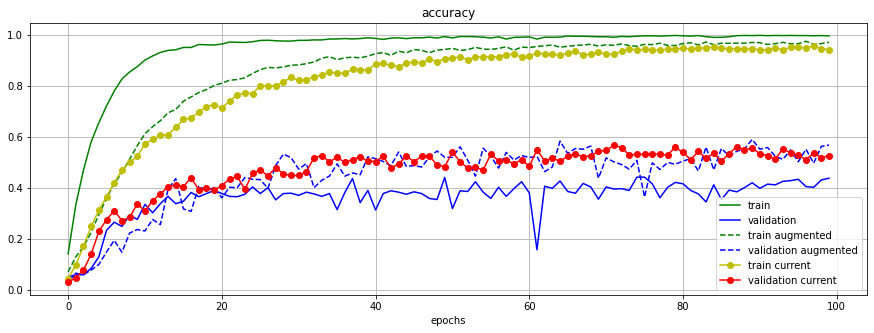

In [41]:
plt.figure(figsize=(15,5))
plt.plot(history_dict_unaugmented['accuracy'],'g-',label='train')
plt.plot(history_dict_unaugmented['val_accuracy'],'b-',label='validation')
plt.plot(history_dict_augmented['accuracy'],'g--',label='train augmented')
plt.plot(history_dict_augmented['val_accuracy'],'b--',label='validation augmented')
plt.plot(history_dict['accuracy'],'yo-',label='train current')
plt.plot(history_dict['val_accuracy'],'ro-',label='validation current')
plt.legend()
plt.xlabel('epochs')
plt.title('accuracy')
#plt.xticks(range(20),range(1,21))
plt.grid(True)

Text(0.5, 1.0, 'Val F1s in the last 20 epochs')

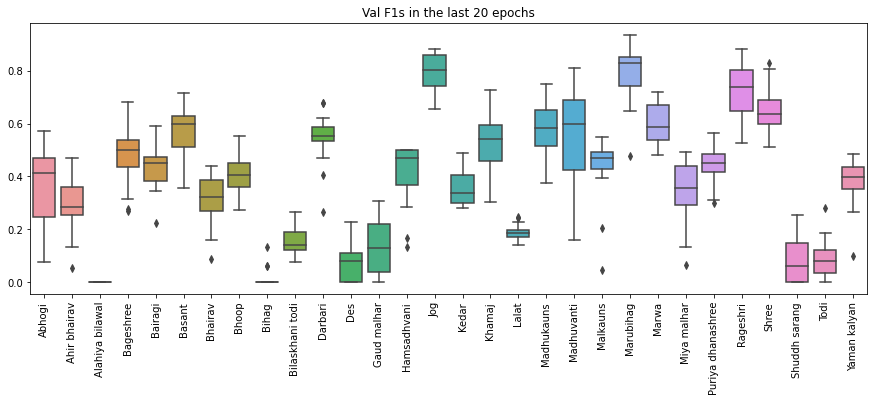

In [42]:
import pandas as pd
import seaborn as sns
fig=plt.figure(figsize=(15,5))
f1s=pd.DataFrame({ragas_reverse_idx[i]:history_dict_unaugmented['val_F1_{}'.format(i)][-20:] for i in range(30)})
ax=sns.boxplot( data=f1s)
ax.get_xticklabels()
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title('Val F1s in the last 20 epochs')

Text(0.5, 1.0, 'Val F1s in the last 20 epochs')

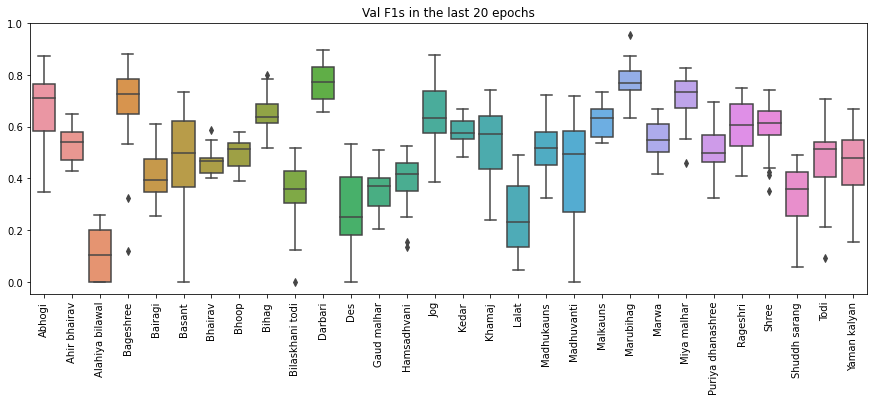

In [43]:
import pandas as pd
import seaborn as sns
fig=plt.figure(figsize=(15,5))
f1s=pd.DataFrame({ragas_reverse_idx[i]:history_dict_augmented['val_F1_{}'.format(i)][-20:] for i in range(30)})
ax=sns.boxplot( data=f1s)
ax.get_xticklabels()
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title('Val F1s in the last 20 epochs')

Text(0.5, 1.0, 'Val F1s in the last 20 epochs')

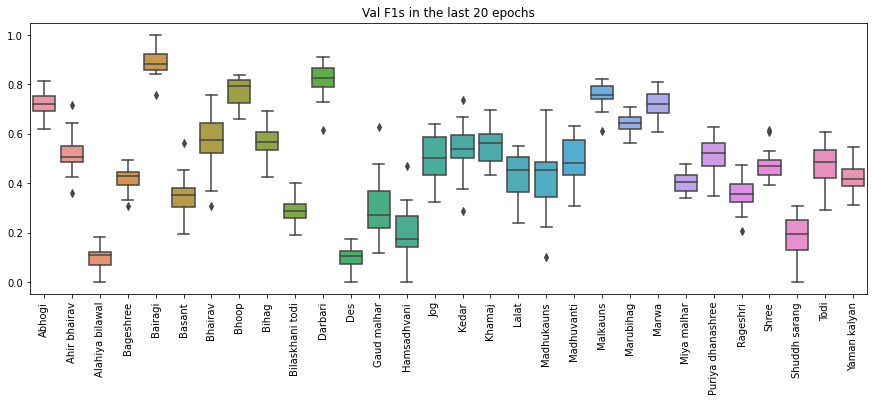

In [44]:
import pandas as pd
import seaborn as sns
fig=plt.figure(figsize=(15,5))
f1s=pd.DataFrame({ragas_reverse_idx[i]:history_dict['val_F1_{}'.format(i)][-20:] for i in range(30)})
ax=sns.boxplot( data=f1s)
ax.get_xticklabels()
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title('Val F1s in the last 20 epochs')

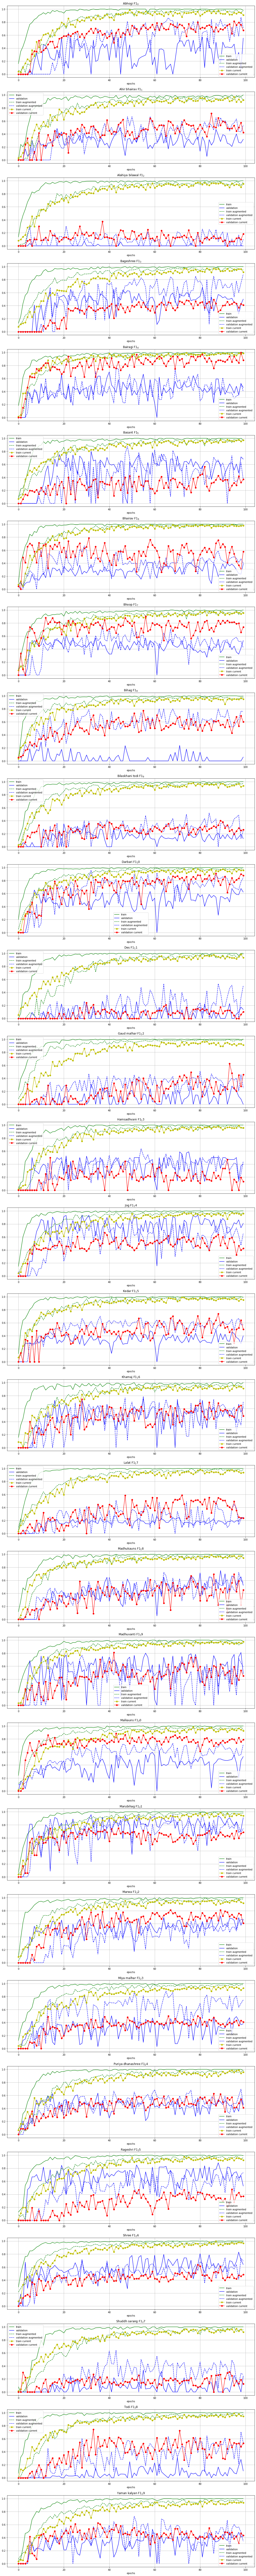

In [46]:
plt.figure(figsize=(15,5*30))
for i in range(30):
    plt.subplot(30,1,i+1)
    plt.plot(history_dict_unaugmented['F1_{}'.format(i)],'g-',label='train')
    plt.plot(history_dict_unaugmented['val_F1_{}'.format(i)],'b-',label='validation')
    plt.plot(history_dict_augmented['F1_{}'.format(i)],'g--',label='train augmented')
    plt.plot(history_dict_augmented['val_F1_{}'.format(i)],'b--',label='validation augmented')
    plt.plot(history_dict['F1_{}'.format(i)],'yo-',label='train current')
    plt.plot(history_dict['val_F1_{}'.format(i)],'ro-',label='validation current')
    plt.title(r'{raga_name} F1$_{raga_id}$'.format(raga_id=i,raga_name=ragas_reverse_idx[i]))
    plt.xlabel('epochs')
    plt.legend()
    plt.grid(True)
plt.tight_layout()

In [47]:
y_pred=np.argmax(model.predict(X_val),axis=-1)
y_true=y_val

In [48]:
cm=tf.math.confusion_matrix(y_true,y_pred,dtype=tf.float32,num_classes=30)


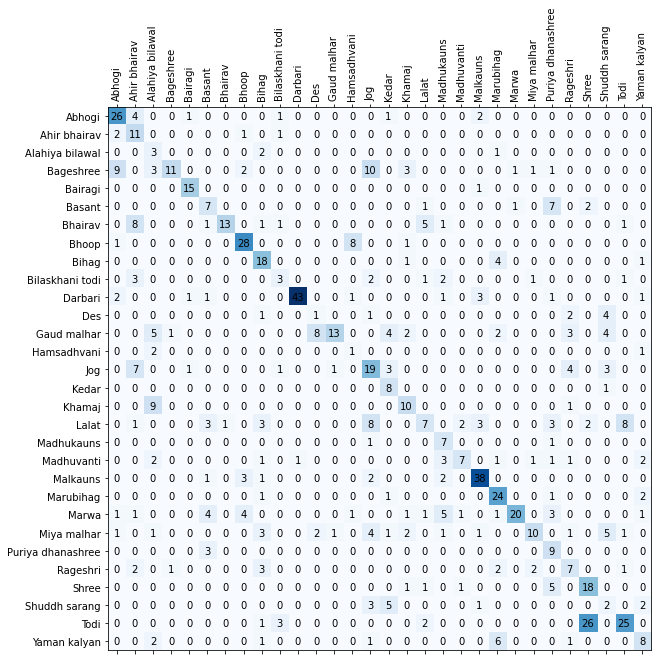

In [49]:
fig, ax = plt.subplots(figsize=(10,10))


cm_matrix = cm.numpy().astype(np.int32)

ax.matshow(cm_matrix, cmap=plt.cm.Blues)

for i in range(30):
    for j in range(30):
        c = cm_matrix[j,i]
        ax.text(i, j, str(c), va='center', ha='center',size=10)
plt.xticks(range(30),[ragas_reverse_idx[i] for i in range(30)],rotation=90)
plt.yticks(range(30),[ragas_reverse_idx[i] for i in range(30)],rotation=0)
plt.show()

In [50]:
def process_confusion_matrix(cm):
    "returns precision, recall and f1 along with overall accuracy"
    diag_part=tf.linalg.diag_part(cm)
    precision=diag_part/(tf.reduce_sum(cm,0)+tf.constant(1e-15))
    recall=diag_part/(tf.reduce_sum(cm,1)+tf.constant(1e-15))
    f1=2*precision*recall/(precision+recall+tf.constant(1e-15))
    return precision,recall,f1

In [51]:
precision,recall,f1=process_confusion_matrix(cm)

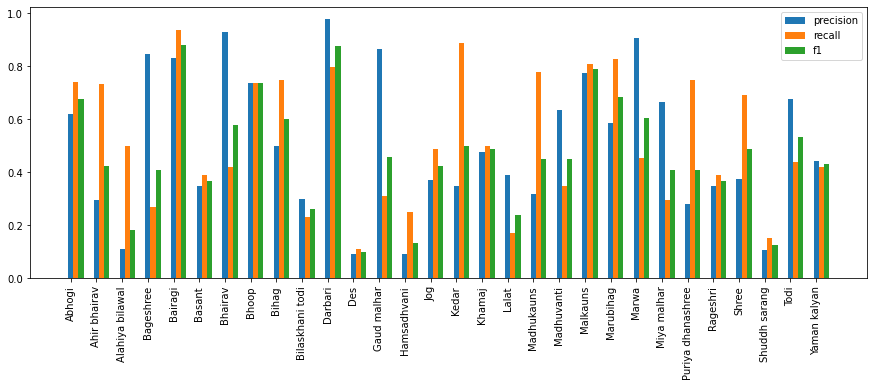

In [53]:
fig=plt.figure(figsize=(15,5))
plt.bar(np.arange(30),precision.numpy(),width=.2,label='precision')
plt.bar(np.arange(30)+.2,recall.numpy(),width=.2,label='recall')
plt.bar(np.arange(30)+.4,f1.numpy(),width=.2,label='f1')
plt.xticks(range(30),[ragas_reverse_idx[i] for i in range(30)],rotation=90)
plt.legend()
plt.show()